In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import math 
import csv
from qmplot import manhattanplot, qqplot
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")

# read in data

In [2]:
def combine_dataframes(directory, ext, pop, sep="\t"): 
    df_list = []
    
    for i in range(1, 23): 
        df = pd.read_csv(f"{directory}/{pop}_{i}{ext}", sep=sep)
        df_list.append(df)
        
    return pd.concat(df_list)

In [3]:
def return_frequency(directory, ext, pop): 
    
    frq = combine_dataframes(directory, ext, pop)
        
    frq["cluster_size"] = frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"]
    frq["name"] = frq["ID"] + "_" + frq["#CHROM"].astype(str)
    frq["maf"] = (frq["TWO_ALT_GENO_CTS"] + (frq["HET_REF_ALT_CTS"]/2))/(frq["HET_REF_ALT_CTS"] + frq["TWO_ALT_GENO_CTS"] + frq["HOM_REF_CT"] )
    
    return frq

In [4]:
def return_assoc(directory, ext, pop): 
    
    assoc = combine_dataframes(directory, ext, pop, " ")
    assoc["name"] = assoc["ID"] + "_" + assoc["CHROM"].astype(str)
    assoc = assoc.dropna(subset=["LOG10P.Y1"])

    return assoc

In [5]:
def return_combined_assoc(name): 
    assoc = pd.read_csv(name, sep=" ")
    assoc["name"] = assoc["ID"] + "_" + assoc["CHROM"].astype(str)
    assoc = assoc.dropna(subset=["LOG10P.Y1"])
    
    return assoc

In [6]:
def perform_qc(assoc, frq, min_hom_count=3, max_frq_maf=0.05, std_thresh=3, qc_type="all"): 
    
    min_hom = frq[frq["TWO_ALT_GENO_CTS"] >= min_hom_count]["name"].values
    max_frq = frq[frq["maf"] < 0.05]["name"].values 
    
    mean, std = frq["cluster_size"].mean(), frq["cluster_size"].std()
    cluster_sharing = set(frq[frq["cluster_size"] <= (std_thresh*std) + mean]["name"].values).intersection(min_hom)
    
    all_intersection = set(cluster_sharing).intersection(set(min_hom)).intersection(set(max_frq))
    
    qc_type_dict = {"maf":max_frq, "min_hom":min_hom, "cluster_sharing":cluster_sharing,
                    "all":all_intersection}
    
    return assoc[assoc["name"].isin(qc_type_dict[qc_type])], qc_type_dict

In [7]:
def multiple_test_correction(df, phenotype_num, test_type="bonferroni"): 
    
    df["P"] = 10**(-df[f"LOG10P.Y{phenotype_num}"])
    
    df[test_type] = multipletests(df["P"], method=test_type)[0]
    df["-log P"] = -(np.log10(df["P"]))

# overall counts 

In [54]:
phecode_name = pd.read_csv("../pheno/phecodeX_info.csv")

In [96]:
all_case_counts = pd.read_csv("../pheno/phecodeTable_BioMe_withSexPhecode_MinCount1_mrn.csv")
all_case_counts = all_case_counts.replace({1:0, 2:1})
all_case_counts = all_case_counts.iloc[:, 2:-3].sum().reset_index()
all_case_counts.columns = ["phecode", "Biome count"]

In [97]:
all_case_counts

,phecode,Biome count
0,BI_160.1,6552
1,BI_160.11,3099
2,BI_160.2,543
3,BI_160.21,231
4,BI_160.22,72
...,...,...
3207,SS_848,2084
3208,SS_849,264
3209,SS_849.1,144
3210,SS_849.3,89


In [90]:
case_counts = pd.read_csv("all_phenotypes_binary/phecodes/pr/regenie/phecodes_all_phen.txt", sep="\t")
case_counts = case_counts.replace({1:0, 2:1})
case_counts = case_counts.iloc[:, 3:].sum().reset_index()
case_counts.columns = ["phecode", "pop case count"]

In [91]:
fdr_sig = pd.read_csv("fdr_sig_phecode_pr.csv")
clique_size = pd.read_csv("all_phenotypes_binary/phecodes/pr/regenie/icurl/combined_count.txt", sep="\t")
fdr_sig["phecode"] = fdr_sig["phecode"].str.strip()

region = pd.read_csv("icurl/libd/pr/cluster2_combined.map", sep=" ", header=None)
region["region"] = "chr" + region[0].astype(str) + ":" + region[2].astype(str) + "-" + region[3].astype(str)

In [92]:
fdr_sig_counts = fdr_sig.merge(case_counts, on="phecode")
fdr_sig_counts_name = fdr_sig_counts.merge(phecode_name, on="phecode")
fdr_sig_counts_name = fdr_sig_counts_name.merge(all_case_counts, on="phecode")
fdr_sig_counts_name = fdr_sig_counts_name.merge(clique_size[["ID", "TWO_ALT_GENO_CTS"]], left_on="name", right_on="ID")
fdr_sig_counts_name = fdr_sig_counts_name.merge(region, left_on="name", right_on=1)

In [94]:
fdr_sig_counts_name.sort_values(by="TWO_ALT_GENO_CTS", ascending=False).head(n=20)

,name,phecode,allele_frq,count,logP,chi,pop case count,phecode_string,category_num,category,...,icd10_only,phecode_num,Biome count,ID,TWO_ALT_GENO_CTS,0,1,2,3,region
4385,c586332_5,NS_343.1,0.014985,7841,3.35978,12.3681,4.0,Peripheral autonomic neuropathy,6,Neurological,...,0,343.100,15,c586332_5,11,5,c586332_5,115000001,115250000,chr5:115000001-115250000
4384,c586332_5,BI_168.213,0.014985,7841,3.46349,12.8144,5.0,Lupus anticoagulant syndrome*,3,Blood/Immune,...,1,168.213,39,c586332_5,11,5,c586332_5,115000001,115250000,chr5:115000001-115250000
4383,c584939_5,SO_361.35,0.015049,7841,3.41217,12.5934,3.0,Paralytic ptosis,7,Sense organs,...,0,361.350,7,c584939_5,11,5,c584939_5,114500001,115000000,chr5:114500001-115000000
4382,c584939_5,NS_343.1,0.015049,7841,3.35978,12.3681,4.0,Peripheral autonomic neuropathy,6,Neurological,...,0,343.100,15,c584939_5,11,5,c584939_5,114500001,115000000,chr5:114500001-115000000
4381,c584939_5,BI_168.213,0.015049,7841,3.46349,12.8144,5.0,Lupus anticoagulant syndrome*,3,Blood/Immune,...,1,168.213,39,c584939_5,11,5,c584939_5,114500001,115000000,chr5:114500001-115000000
4380,c583124_5,SO_361.35,0.015177,7841,3.41217,12.5934,3.0,Paralytic ptosis,7,Sense organs,...,0,361.350,7,c583124_5,11,5,c583124_5,114250001,114500000,chr5:114250001-114500000
4379,c583124_5,NS_343.1,0.015177,7841,3.35978,12.3681,4.0,Peripheral autonomic neuropathy,6,Neurological,...,0,343.100,15,c583124_5,11,5,c583124_5,114250001,114500000,chr5:114250001-114500000
4378,c583124_5,BI_168.213,0.015177,7841,3.46349,12.8144,5.0,Lupus anticoagulant syndrome*,3,Blood/Immune,...,1,168.213,39,c583124_5,11,5,c583124_5,114250001,114500000,chr5:114250001-114500000
4386,c586332_5,SO_361.35,0.014985,7841,3.41217,12.5934,3.0,Paralytic ptosis,7,Sense organs,...,0,361.350,7,c586332_5,11,5,c586332_5,115000001,115250000,chr5:115000001-115250000
4376,c581736_5,NS_343.1,0.014922,7841,3.35978,12.3681,4.0,Peripheral autonomic neuropathy,6,Neurological,...,0,343.100,15,c581736_5,11,5,c581736_5,114000001,114250000,chr5:114000001-114250000


In [46]:
# fdr_sig_counts_name.to_csv("fdr_sig_counts_name_aj.csv", index=False)

In [21]:
fdr_sig_counts_name.groupby("name")["phecode_string"].nunique().sort_values(ascending=False)

name
c523114_9     10
c523720_9     10
c524914_9     10
c519506_9     10
c527758_9     10
              ..
c585698_6      1
c586072_7      1
c586651_8      1
c580402_10     1
c580554_7      1
Name: phecode_string, Length: 4120, dtype: int64

### make dataframes

In [68]:
directory = "all_phenotypes_binary/phecodes/pr/regenie/icurl/"
ext = "_CM_760"
pop="pr"

# assoc = return_assoc(directory, f"{ext}.regenie", pop)
assoc = return_combined_assoc(f"{directory}{pop}{ext}_combined.regenie")
frq = return_frequency(directory, ".gcount", pop)
# case_frq = return_frequency(directory, f"{ext}_case.gcount", pop)

In [69]:
# case_counts[case_counts["index"] == ext[1:]]

In [70]:
assoc["CHROM"].nunique()

22

# qc 

### run QC 

In [71]:
assoc_qc, qc_dict = perform_qc(assoc, frq, qc_type="min_hom", std_thresh=3, min_hom_count=3, max_frq_maf=0.01)

In [72]:
len(qc_dict["maf"]), len(qc_dict["min_hom"]), len(qc_dict["cluster_sharing"]), len(qc_dict["all"])

(3798801, 6678, 649, 649)

In [73]:
# assoc_qc = assoc_qc[assoc_qc["OR"] >= 1]

In [74]:
multiple_test_correction(assoc_qc, 1, test_type="fdr_bh")

In [75]:
# assoc_qc = assoc_qc[assoc_qc["BETA.Y2"] >= 0]

# plots

### P value histogram 

In [76]:
# sns.histplot(x="P", data=assoc_qc, color="#9B97B2")
# plt.show()

### QQ plot

In [77]:
# qqplot(data=assoc_qc["P"], color="#73A6AD", alpha=1)
# sns.despine()
# plt.show()

### manhattan plot

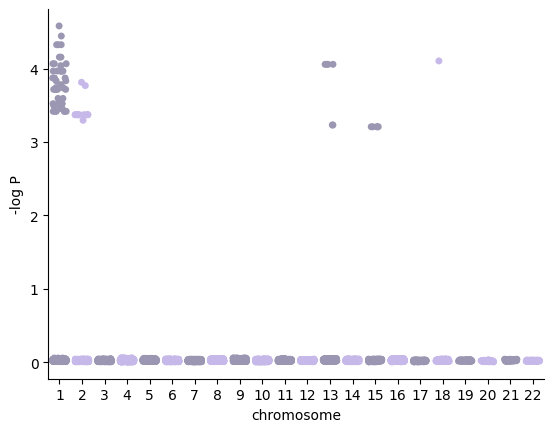

In [78]:
order = [str(i) for i in range(1, 23)]
bonf_line = -np.log10(0.05/len(assoc_qc))

sns.stripplot(x="CHROM", y="-log P", data=assoc_qc, order=order, jitter=0.3, 
               palette=sns.color_palette(["#9B97B2", "#C7B8EA"]*11))

# plt.axhline(y=bonf_line, linestyle="--", color="lightgrey") 
plt.xlabel("chromosome")
sns.despine()
plt.show()

In [79]:
assoc_qc[assoc_qc["CHROM"] ==3].sort_values(by="P").head(n=20)

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA.Y1,SE.Y1,CHISQ.Y1,LOG10P.Y1,EXTRA,name,P,fdr_bh,-log P
101649,3,165500000,c829675_3,1,2,0.013200,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c829675_3_3,0.896273,False,0.047560
101659,3,165750000,c831273_3,1,2,0.013327,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c831273_3_3,0.896273,False,0.047560
101673,3,166000000,c832258_3,1,2,0.013264,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c832258_3_3,0.896273,False,0.047560
101706,3,167250000,c835994_3,1,2,0.013646,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c835994_3_3,0.896273,False,0.047560
101714,3,167500000,c836705_3,1,2,0.013455,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c836705_3_3,0.896273,False,0.047560
101692,3,166750000,c834302_3,1,2,0.013583,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c834302_3_3,0.896273,False,0.047560
101683,3,166250000,c833048_3,1,2,0.013519,7841,REC,-1.01067,7.75224,0.016997,0.047560,NaN,c833048_3_3,0.896273,False,0.047560
101737,3,168000000,c839685_3,1,2,0.013646,7841,REC,-1.01136,8.37947,0.014567,0.043864,NaN,c839685_3_3,0.903933,False,0.043864
101726,3,167750000,c838121_3,1,2,0.012817,7841,REC,-1.01136,8.37947,0.014567,0.043864,NaN,c838121_3_3,0.903933,False,0.043864
93477,3,9000000,c921612_3,1,2,0.005101,7841,REC,-1.00760,8.45688,0.014196,0.043275,NaN,c921612_3_3,0.905160,False,0.043275


In [80]:
map_file = pd.read_csv("icurl/libd/pr/cluster2_3.map", sep=" ", header=None)
# frq_file = pd.read_csv("comparison/cirrhosis/regenie/icurl/cluster2_4.gcount", sep="\t")
# case_frq_file = pd.read_csv("comparison/cirrhosis/regenie/icurl/cluster2_4_case.gcount", sep="\t")
# map_file["size"] = map_file[3] - map_file[2]
map_file["region"] = "chr" + map_file[0].astype(str) + ":" + map_file[2].astype(str) + "-" + map_file[3].astype(str)

In [81]:
snp = "c829675_3"

In [82]:
map_file[map_file[1] == snp]

,0,1,2,3,region
174943,3,c829675_3,165250001,165500000,chr3:165250001-165500000


In [84]:
clique_size[clique_size["ID"] == "c851240_12"]

,#CHROM,ID,REF,ALT,PROVISIONAL_REF?,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
559212,12,c851240_12,1,2,Y,7593,2,0,0,0,0
4334410,12,c851240_12,1,2,Y,7849,147,4,0,0,0


In [ ]:
d = pd.read_csv("all_phenotypes_binary/phecodes/pr/regenie/icurl/")